# Training

In [25]:
# Parameters cells
WITNESS_NAME = "CONCURRENCE"
SIMULATION_PATH = "./simulated_data"
MLFLOW_URL = None #"http://localhost:5000"
AIRFLOW_DAG_RUN_ID = None #"test-dm-chsh"
AWS_ACCESS_KEY_ID="minio123"
AWS_SECRET_ACCESS_KEY="minio123"
MLFLOW_S3_ENDPOINT_URL="http://localhost:9990"

In [26]:
from os import environ

environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY

In [27]:
import numpy as np
import tensorflow as tf;
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from entanglement_witnesses import witnesses
import mlflow
import os

In [28]:
if MLFLOW_URL is not None:
    mlflow.set_tracking_uri(MLFLOW_URL)
    environ["MLFLOW_S3_ENDPOINT_URL"] = MLFLOW_S3_ENDPOINT_URL

In [29]:
def get_model(name, data_file_path):

    data = np.load(data_file_path)
    simulated_states = data["states"]
    simulated_labels = data["labels"]

    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(simulated_states.shape[1],)), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    X_train, X_val, y_train, y_val = train_test_split(simulated_states, simulated_labels, test_size=0.2, random_state=42)
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))
    loss, accuracy = model.evaluate(X_val, y_val)

    metrics = {
        "loss": loss,
        "accuracy": accuracy
    }

    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model {} Accuracy'.format(name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model {} Loss'.format(name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return model, metrics

In [30]:
def get_simulation_data_path(name):
    filename = "simulation-{}.npz".format(name)
    if AIRFLOW_DAG_RUN_ID is None:
        data_file_path = os.path.join("./simulated_data", filename)
    else:
        client = mlflow.tracking.MlflowClient()

        experiments = client.search_experiments(
            filter_string = "name = 'ML Quantum Entanglement'"
        )
        experiment_id = experiments[0].experiment_id

        runs = client.search_runs(
            experiment_ids=[experiment_id], 
            filter_string=f"tags.airflow_dag_run_id = '{AIRFLOW_DAG_RUN_ID}'"
        )
        run_id = runs[0].info.run_id
        local_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="simulated_data")
        data_file_path = os.path.join(local_path, filename)
    return data_file_path

In [31]:
from simulation_utils import flatten_density_matrix
from qutip import rand_dm

def log_mlflow_model(model, witness_name, metrics):
    if MLFLOW_URL is None:
        return
    
    mlflow.set_experiment('ML Quantum Entanglement')

    input_example = tf.constant(flatten_density_matrix(rand_dm(4)))
    
    # Start an MLflow run and log the model
    with mlflow.start_run() as run:
        # Log the model
        mlflow.tensorflow.log_model(model, "model", input_example)

        # Log parameters
        mlflow.log_param("witness", witness_name)

        # Evaluate the model and log metrics
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(metric_name, metric_value)

        # Register the model
        model_name = "QuantumStateClassifier-" + witness_name
        model_uri = f"runs:/{run.info.run_id}/model"
        mlflow.register_model(model_uri, model_name)
        print(f"Model saved in run {run.info.run_id}")

Epoch 1/20


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6757 - loss: 0.6255 - val_accuracy: 0.9486 - val_loss: 0.3398
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.9737 - loss: 0.2299 - val_accuracy: 0.9871 - val_loss: 0.0848
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.9903 - loss: 0.0685 - val_accuracy: 0.9871 - val_loss: 0.0529
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.9933 - loss: 0.0412 - val_accuracy: 0.9886 - val_loss: 0.0441
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.9956 - loss: 0.0285 - val_accuracy: 0.9943 - val_loss: 0.0369
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.9921 - loss: 0.0293 - val_accuracy: 0.9871 - val_loss: 0.0345
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9914 - loss: 0.0233 - val_accuracy: 0.9914 - val_loss: 0.0296
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.9975 - loss: 0.0193 - val_accuracy: 0.9900 - val_loss

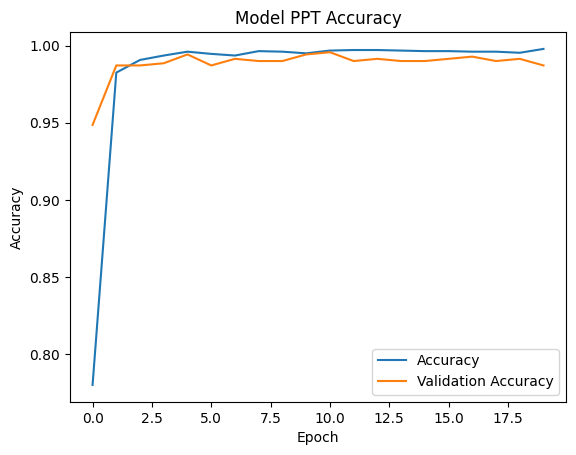

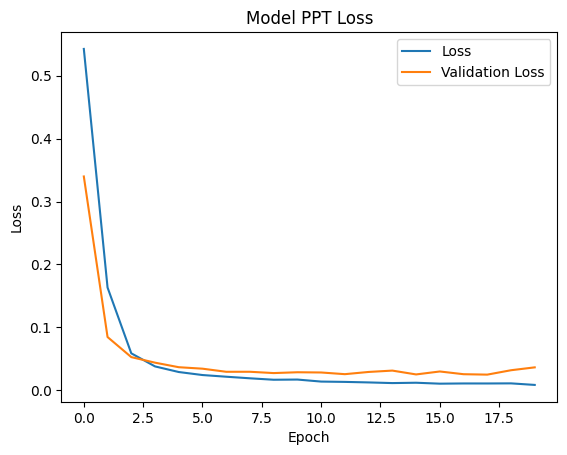

In [32]:
models = {}
if WITNESS_NAME is not None:
    parameter_witnesses = {WITNESS_NAME: witnesses[WITNESS_NAME]}
else: 
    parameter_witnesses = witnesses

for name, witness in parameter_witnesses.items():
    data_file_path = get_simulation_data_path(name)
    model, metrics = get_model(name, data_file_path)
    log_mlflow_model(model, name, metrics)
    models[name] = {"model": model, "witness": witness}
